In [1]:
import s3fs
import pyarrow as pa
import pyarrow.dataset as ds

import sys
import os

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

import pandas as pd
import polars as pl
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

from pyspark.sql.functions import *

In [2]:
spark = SparkSession.builder.remote("sc://vlenpmod302spk3.hevs.ch:15002").getOrCreate()

In [3]:
df=spark.read.parquet("hdfs://vlenpmod302spk1.hevs.ch:9000/mod302/nyc-taxi.parquet")
df.show(2)

+---------+-------------------+-------------------+---------------+-------------+----------------+---------------+------------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+------------+---------------------+------------------+-------------------+--------------------+----+-----+---+
|vendor_id|          pickup_at|         dropoff_at|passenger_count|trip_distance|pickup_longitude|pickup_latitude|rate_code_id|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|total_amount|improvement_surcharge|pickup_location_id|dropoff_location_id|congestion_surcharge|year|month|day|
+---------+-------------------+-------------------+---------------+-------------+----------------+---------------+------------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+------------+---------------------+-----------

In [4]:
'''zones = pd.read_csv('taxi_zone_lookup.csv')
manhatZones = zones[zones["Borough"] == "Manhattan"]
manhatZones["LocationID"].tolist()'''
manhatZones = [4, 12, 13, 24, 41, 42, 43, 45, 48, 50, 68, 74, 75, 79, 87, 88, 90, 100, 103, 104, 105, 107, 113, 114, 116, 120, 125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]

In [5]:
idInMan = df.filter(df.pickup_location_id.isNotNull()) \
    .filter(df.dropoff_location_id.isNotNull()) \
    .filter(df.year == 2019) \
    .filter(df.pickup_location_id.isin(manhatZones)) \
    .filter(df.dropoff_location_id.isin(manhatZones)) \
    #.count()

In [16]:
idInMan = idInMan.withColumn("trip_duration", F.unix_timestamp("dropoff_at") - F.unix_timestamp("pickup_at"))
idInMan.show(2)

+---------+-------------------+-------------------+---------------+-------------+----------------+---------------+------------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+------------+---------------------+------------------+-------------------+--------------------+----+-----+---+-------------+
|vendor_id|          pickup_at|         dropoff_at|passenger_count|trip_distance|pickup_longitude|pickup_latitude|rate_code_id|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|total_amount|improvement_surcharge|pickup_location_id|dropoff_location_id|congestion_surcharge|year|month|day|trip_duration|
+---------+-------------------+-------------------+---------------+-------------+----------------+---------------+------------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+------------+-----

In [78]:
# output of this is stocked in nPerIdReport.txt
for i in manhatZones:
    print("Zone ", i, ":")
    print("pickup = ", idInMan.select('pickup_location_id').where(idInMan.pickup_location_id==i).count())
    print("dropoff = ", idInMan.select('dropoff_location_id').where(idInMan.dropoff_location_id==i).count()) 

Zone  4 :
pickup =  70512
dropoff =  189173
Zone  12 :
pickup =  14941
dropoff =  24795
Zone  13 :
pickup =  349272
dropoff =  378159
Zone  24 :
pickup =  128777
dropoff =  148362
Zone  41 :
pickup =  160422
dropoff =  270537
Zone  42 :
pickup =  67445
dropoff =  176945
Zone  43 :
pickup =  649035
dropoff =  554774
Zone  45 :
pickup =  72126
dropoff =  107288
Zone  48 :
pickup =  1315872
dropoff =  1150688
Zone  50 :
pickup =  372541
dropoff =  511543
Zone  68 :
pickup =  1000138
dropoff =  970119
Zone  74 :
pickup =  154912
dropoff =  336520
Zone  75 :
pickup =  304730
dropoff =  525087
Zone  79 :
pickup =  1026269
dropoff =  938624
Zone  87 :
pickup =  261806
dropoff =  310148
Zone  88 :
pickup =  137661
dropoff =  155732
Zone  90 :
pickup =  733388
dropoff =  627855
Zone  100 :
pickup =  829110
dropoff =  648031
Zone  103 :
pickup =  0
dropoff =  0
Zone  104 :
pickup =  0
dropoff =  0
Zone  105 :
pickup =  54
dropoff =  39
Zone  107 :
pickup =  941291
dropoff =  886098
Zone  113 :
p

taxis ayant les infos en 2019: 44.5M
taxis ayant les infos en 2019 et commencant/terminant a Manhattan 37.5M

In [12]:
from pyspark.sql import functions as F

idInMan.groupBy(["pickup_location_id", "dropoff_location_id"]).count().sort("count",ascending=False).show(500)

+------------------+-------------------+------+
|pickup_location_id|dropoff_location_id| count|
+------------------+-------------------+------+
|               237|                236|284361|
|               236|                236|246330|
|               236|                237|241587|
|               237|                237|227886|
|               239|                238|128551|
|               239|                142|122974|
|               142|                239|117165|
|               161|                237|115879|
|               237|                162|115201|
|               237|                161|113923|
|               238|                239|112781|
|               141|                236|106550|
|               186|                161|103340|
|               186|                230|103252|
|                48|                 48|102993|
|               239|                239| 98889|
|               237|                141| 97965|
|               263|                236|

Geo json source:
https://github.com/codeforgermany/click_that_hood/blob/main/public/data/new-york-city-boroughs.geojson

In [19]:
id164113 = idInMan.filter(idInMan['pickup_location_id'] == 164) \
                    .filter(idInMan['dropoff_location_id'] == 113) \
                    .toPandas()
                    #.count()
id164113 = id164113[id164113["trip_duration"] < 5000]

In [31]:
id164113ForCorr = id164113[["trip_duration"]]
id164113ForCorr["hour_pick"] = pd.DatetimeIndex(id164113['pickup_at']).hour
id164113ForCorr["hour_drop"] = pd.DatetimeIndex(id164113['dropoff_at']).hour

C:\Users\sebbo\AppData\Local\Temp\ipykernel_6500\4225886444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id164113ForCorr["hour_pick"] = pd.DatetimeIndex(id164113['pickup_at']).hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_6500\4225886444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id164113ForCorr["hour_drop"] = pd.DatetimeIndex(id164113['dropoff_at']).hour


In [32]:
id164113ForCorr

,trip_duration,hour_pick,hour_drop
0,477,1,1
1,330,2,2
2,347,3,3
3,483,7,7
4,311,7,7
...,...,...,...
22087,430,23,0
22088,201,23,23
22089,373,0,0
22090,727,23,0


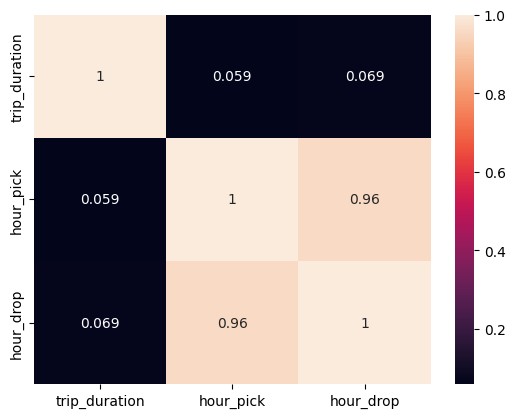

In [33]:
ax = sns.heatmap(id164113ForCorr.corr(), annot=True)

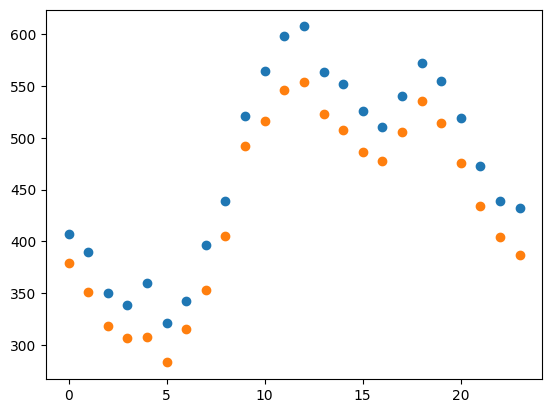

In [40]:
idMean = id164113ForCorr.groupby(['hour_pick']).mean()
idMed = id164113ForCorr.groupby(['hour_pick']).median()
plt.scatter(idMean.index,idMean["trip_duration"],)
plt.scatter(idMed.index,idMed["trip_duration"])
plt.show()

In [1]:
# init du bas
spark = SparkSession.builder.remote("sc://vlenpmod302spk3.hevs.ch:15002").getOrCreate()
df=spark.read.parquet("hdfs://vlenpmod302spk1.hevs.ch:9000/mod302/nyc-taxi.parquet")

NameError: name 'SparkSession' is not defined

In [67]:
def get_samples():
    data = df.filter(df.dropoff_longitude.isNotNull()) \
        .filter(df.dropoff_latitude.isNotNull()) \
        .filter(df.pickup_longitude.isNotNull()) \
        .filter(df.pickup_latitude.isNotNull()) \
        .filter(df.dropoff_longitude != 0) \
        .filter(df.dropoff_latitude != 0) \
        .filter(df.pickup_longitude != 0) \
        .filter(df.pickup_latitude != 0) \
        .filter(df.year == 2016) \
        .sample(0.00005) \
        .toPandas() # renvoie quelques centaines de resultats
    
    X = data[["pickup_longitude", "dropoff_longitude", "pickup_latitude", "dropoff_latitude", "month", "day"]]
    X["hour"] = data["pickup_at"].dt.hour
    y_raw = data[["dropoff_at","pickup_at"]]
    y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
    y = pd.DataFrame(columns = ["travel_time"])
    y["travel_time"] = y_raw["travel_time"]
    return X,y

In [68]:
# creation du modele
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
robust = RobustScaler()

allTraining_X = pd.DataFrame(columns = ["pickup_longitude", "dropoff_longitude", "pickup_latitude", "dropoff_latitude", "month", "day", "hour"])
allTraining_y = pd.DataFrame(columns = ["travel_time"])
    
margin = 300 # [seconds]


def trainModel(X,y):
    global allTraining_X
    global allTraining_y
    scaX = robust.fit_transform(X) if len(allTraining_X) == 0 else robust.transform(X) 
    model.fit(scaX,y)
    pdScaX = pd.DataFrame(scaX, columns=["pickup_longitude", "dropoff_longitude", "pickup_latitude", "dropoff_latitude", "month", "day", "hour"])
    allTraining_X = pd.concat([allTraining_X, pdScaX], ignore_index=True)
    allTraining_y = pd.concat([allTraining_y, y], ignore_index=True)

def testModel(X,y):
    scaX = robust.transform(X)
    y_pred = model.predict(scaX)
    #y_pred = pd.DataFrame(y_pred, columns=["travel_time"])

    yDiff = y_pred - y
    yDiffTrue = yDiff[yDiff.travel_time > -margin]
    yDiffTrue = yDiffTrue[yDiffTrue.travel_time < margin]
    prec = len(yDiffTrue) / len(y_pred) * 100
    #mse = root_mean_squared_error(y, y_pred)
    return prec

def evaluateAllTrain():
    y_pred = model.predict(allTraining_X)
    #y_pred = pd.DataFrame(y_pred, columns=["travel_time"])
    
    yDiff = y_pred - allTraining_y
    yDiffTrue = yDiff[yDiff.travel_time > -margin]
    yDiffTrue = yDiffTrue[yDiffTrue.travel_time < margin]
    prec = len(yDiffTrue) / len(y_pred) * 100
    #mse = root_mean_squared_error(allTraining_y, y_pred)
    return prec


In [69]:
# cycle d'entrainement
def trainingCycle():
    X,y = get_samples()
    trainModel(X,y)

def testingCycle():
    X,y = get_samples()
    return testModel(X,y)

In [70]:
trainMSE = []
testMSE = []

In [88]:
count = 0
while(True):
    trainingCycle()
    trainingCycle()
    trainMSE.append(evaluateAllTrain())
    testMSE.append(testingCycle())
    print(count)
    count += 1

C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

0


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

1


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

2


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

3


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

4


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

5


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

6


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

7


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

8


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

9


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

10


C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

KeyboardInterrupt: 

In [93]:
testMSE

[67.51404079219627,
 66.20830895260387,
 67.99065420560748,
 65.58499553438524,
 68.77224199288257,
 68.2150160677768,
 65.77337605592776,
 67.6310512747064,
 66.84318917328626,
 67.20844026233249,
 67.48159057437408,
 67.0228554467201,
 67.1281296023564,
 66.87333923826395,
 67.06337399583458,
 67.27272727272727,
 66.62766890903772,
 68.36384439359267,
 66.82366794230204,
 65.71925754060325,
 66.99259259259259,
 65.38904899135447,
 67.50438340151958,
 66.8829253907402,
 66.39712488769092,
 66.41724034720143,
 66.93075117370893,
 67.27973894986651,
 67.11229946524064,
 66.5904544155473,
 68.03061524874889,
 67.46055373623102]

239663


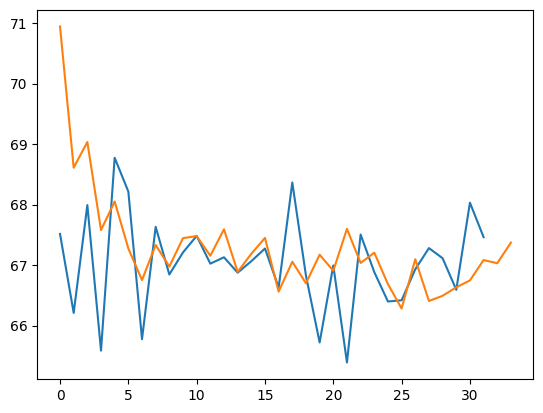

In [89]:
print(len(allTraining_X))
plt.plot(testMSE)
plt.plot(trainMSE)

In [109]:
X,y = get_samples()

C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hour"] = data["pickup_at"].dt.hour
C:\Users\sebbo\AppData\Local\Temp\ipykernel_22896\2922932306.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw["travel_time"] = (y_raw["dropoff_at"] - y_raw["pickup_at"]).dt.total_seconds()


In [111]:
scaX = robust.transform(X)
y_pred = model.predict(scaX)
y_pred

array([[  268.2],
       [  845.2],
       [ 1146.8],
       ...,
       [17638.2],
       [  485.4],
       [  312. ]])

In [53]:
trainMSE


[3218.7863222079304,
 2355.6204154991015,
 2727.4006396429813,
 2401.722778642368,
 2166.337434809492,
 1982.1745595360567,
 2319.7665673710153,
 2474.3570419793696,
 2591.321468050809,
 2652.7695186311216,
 2533.383586316976,
 2924.095358656999,
 3088.4942793840687,
 2988.740640294767,
 2894.9819026102227,
 3039.7239829783534,
 3053.419099892718,
 3073.2782273647013,
 3098.5864478138437,
 3118.7140673818362,
 3041.4400407956946,
 3213.77281460598,
 3219.5551495908685,
 3222.135710094535,
 3222.353043452181,
 3230.186254660076,
 3233.2997389797265,
 3182.0004787111534]

In [97]:
import pickle
# init
def initModel(path):
    return pickle.load(open(path, 'rb'))

loadedModel = initModel("./taxi_knr_240k.sav")
loadedScaler = initModel("./taxi_scaler_240k.sav")

In [110]:
scaX = loadedScaler.transform(X)
y_pred = model.predict(scaX)
y_pred

array([[  268.2],
       [  845.2],
       [ 1146.8],
       ...,
       [17638.2],
       [  485.4],
       [  312. ]])

In [121]:
import numpy as np

def getTaxiTripLength(longIn, latIn, longOut, latOut, month, day, hour) -> float: # returns the estimated trip length in seconds
    scaledX = loadedScaler.transform(np.array([latIn, latOut, longIn, longOut,month,day,hour]).reshape(1, -1))  
    return loadedModel.predict(scaledX)[0][0]

  
#getTaxiTripLength(40.715235, -74.004636, 40.722586, -73.983429,1,1,12)
#getTaxiTripLength(40.740667,-73.985664,40.732342,-73.996139,1,1,12)
getTaxiTripLength(40.732342,-73.996139,40.81788,-73.945713,1,1,12)


C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1444.2

In [96]:
import pickle

# save the model to disk
filename = 'taxi_scaler_240k.sav'
pickle.dump(robust, open(filename, 'wb'))

In [ ]:
# test
getTaxiTripLength()

In [22]:
df_places = gpd.read_file('new-york-city-boroughs.geojson')